### 1. Build Image Index

In [6]:
import os
import glob
import time
import uuid
import tqdm
import torch
import random
from PIL import Image
from torchvision import transforms
from model.AlexNet import AlexNet
from utils.dataset import build_dataloader
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct, SearchRequest

In [7]:
IMAGE_SIZE = 128
EMBEDDING_SIZE = 64
BATCH_SIZE = 100
MODEL_PATH = "./weights/model_best.pth"
DATASET_PATH = "./dataset/train"
COLLECTION_NAME = "bird_species_alexnet_64d"
IMAGES_PATH = glob.glob(DATASET_PATH+"/*/*")
DEVICE = torch.device("cuda:0")

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

dataset, dataloader = build_dataloader(
    batch_size=BATCH_SIZE,
    root_dir=DATASET_PATH,
    transform=transform,
    shuffle=False,
    num_workers=4,
)

model = AlexNet(input_size=IMAGE_SIZE, embedding_size=EMBEDDING_SIZE).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# Initialize qdrant client
client = QdrantClient(host="localhost", port=6333)
client = QdrantClient(
    host="localhost",
    port=6333,
    grpc_port=6334,
    prefer_grpc=True
)

In [9]:
# check if collection exists
existing_collections = [c.name for c in client.get_collections().collections]

# create collection if  doesn't exists
if not (COLLECTION_NAME in existing_collections):
    client.recreate_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(size=EMBEDDING_SIZE, distance=Distance.COSINE),
    )

total_records_qdrant = client.http.collections_api.get_collection(
    COLLECTION_NAME
).dict()["result"]["vectors_count"]

print(f"Total records inside Qdrant: {total_records_qdrant}")

Total records inside Qdrant: 72876


In [167]:
# if you want to re-write the entire index, delete old collection and re-create it.
print(f"Recreating collection: {COLLECTION_NAME}")
client.delete_collection(collection_name=COLLECTION_NAME)
client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=EMBEDDING_SIZE, distance=Distance.COSINE),
)

total_records_qdrant = client.http.collections_api.get_collection(
    COLLECTION_NAME
).dict()["result"]["vectors_count"]

print(f"Total records inside Qdrant: {total_records_qdrant}")

Recreating collection: bird_species_alexnet_64d
Total records inside Qdrant: 0


In [7]:
print(f"batch size: {BATCH_SIZE}, total images to index: {len(glob.glob(DATASET_PATH+'/*/*'))}")

st = time.time()
for batch_idx, (images_batch, labels_batch) in enumerate(tqdm.tqdm(dataloader)):
    with torch.no_grad():
        embeddings = model(images_batch.to(DEVICE)).cpu().numpy()

    points = []
    for embedding, label in zip(embeddings, labels_batch):
        idx = label.item()
        embedding = embedding.tolist()
        label = dataset.label_decode[idx]

        payload_id = uuid.uuid1().int >> 64
        points.append(
            PointStruct(
                id=payload_id,
                payload={"label": label},
                vector=embedding,
            )
        )
    
    # Insert new embeding vector and it's label inside qdrant
    client.upsert(collection_name=COLLECTION_NAME, points=points, wait=True)

total_records_qdrant = client.http.collections_api.get_collection(
    COLLECTION_NAME
).dict()["result"]["vectors_count"]

print(f"Elapsed: {time.time() - st} seconds")
print(f"Total records inside Qdrant: {total_records_qdrant}")

batch size: 100, total images to index: 70626


100%|██████████████████████████████████| 707/707 [00:40<00:00, 17.48it/s]

Elapsed: 40.458065032958984 seconds
Total records inside Qdrant: 70626


In [ ]:
##### Indexing can also be done with provided script #####
# 1. delete old indexes and index all train images
!python ./build_index.py \
    --dataset_path ./dataset/train \
    --model_path ./weights/model_best.pth \
    --image_size 128 \
    --embedding_size 64 \
    --batch_size 500 \
    --overwrite

In [ ]:
# 2. Add new index from validation images
!python ./build_index.py \
    --dataset_path ./dataset/valid \
    --model_path ./weights/model_best.pth \
    --image_size 128 \
    --embedding_size 64 \
    --batch_size 500

### 2. Predict label for a single image

GT: BLACK THROATED BUSHTIT, Predicted: BLACK THROATED BUSHTIT, is_correct: ✅


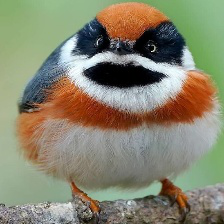

In [27]:
import numpy as np

# pick a random index
idx = random.randint(0, len(IMAGES_PATH))
image = Image.open(IMAGES_PATH[idx])
label = os.path.basename(os.path.dirname(IMAGES_PATH[idx]))

with torch.no_grad():
    # model inference
    image_batch = torch.unsqueeze(transform(image).to(DEVICE), 0)
    embedding_batch = model(image_batch)
    embedding = embedding_batch[0].cpu().numpy().tolist()

# build embedding search queries
search_queries = [
    SearchRequest(
        vector=embedding,
        filter=None,
        limit=1,
        with_payload=True,
    )
]

# Search for matching embedding vector and it's label in qdrant db
res = client.search_batch(collection_name=COLLECTION_NAME, requests=search_queries)
predicted = [r[0].payload["label"] for r in res][0]

# show results
print(f"GT: {label}, Predicted: {predicted}, is_correct: {'✅' if (label == predicted) else '❌'}")
display(image)

### 3. Predict label for a batch of images

GT: CREAM COLORED WOODPECKER, Predicted: CREAM COLORED WOODPECKER, is_correct: ✅


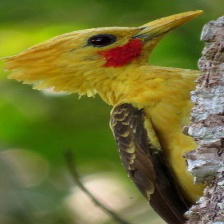


GT: BLUE COAU, Predicted: BLUE COAU, is_correct: ✅


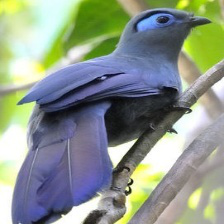


GT: STEAMER DUCK, Predicted: STEAMER DUCK, is_correct: ✅


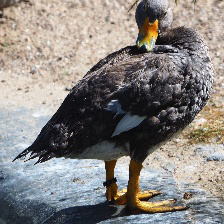


GT: RED BROWED FINCH, Predicted: RED BROWED FINCH, is_correct: ✅


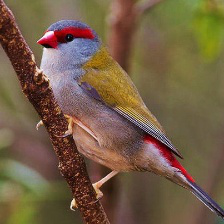


GT: BANDED STILT, Predicted: BANDED STILT, is_correct: ✅


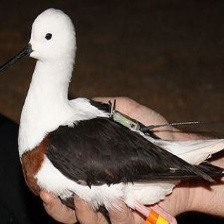

In [200]:
import numpy as np

# pick n random indexes
num_images_to_predict = 5
idxes = np.random.choice(len(IMAGES_PATH), num_images_to_predict)

# load n images and it's labels
images = [Image.open(IMAGES_PATH[idx]) for idx in idxes]
labels = [os.path.basename(os.path.dirname(IMAGES_PATH[idx])) for idx in idxes]

with torch.no_grad():
    # model inference
    image_batch = torch.cat([torch.unsqueeze(transform(i), 0) for i in images]).to(DEVICE)
    embedding_batch = model(image_batch).cpu().numpy().tolist()

# build embedding search queries
search_queries = [
    SearchRequest(
        vector=embedding,
        filter=None,
        limit=1,
        with_payload=True,
    ) for embedding in embedding_batch
]

# Search for matching embedding vector and it's label in qdrant db
res = client.search_batch(collection_name=COLLECTION_NAME, requests=search_queries)
predicted = [r[0].payload["label"] for r in res]

# show results
for image, label, predicted in zip(images, labels, predicted):
    print(f"GT: {label}, Predicted: {predicted}, is_correct: {'✅' if (label == predicted) else '❌'}")
    display(image)
    print()